# Research Question 1: What continuous features most strongly influence the rankings on the website?
## Importing Libraries

In [59]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from scipy.stats import shapiro, anderson, jarque_bera, spearmanr, probplot
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve

## Loading dataframes

In [22]:
df_17 = pd.read_csv(f'data/2017/basic_data_2017.csv', index_col='Unnamed: 0', encoding='utf-8') 
df_23 = pd.read_csv(f'data/2023/basic_data_2023.csv', index_col='Unnamed: 0', encoding='utf-8')
df_list = [df_17, df_23]

## Checking Normality/looking at correlations

In [9]:
# Jarque-Bera because it's well over 3000
stat, p = jarque_bera(df_17['geek_rating'])
print('Statistics=%.3f, p=%.3f' % (stat,p))

result = anderson(df_23['geek_rating'])
for i in range(len(result.critical_values)):
 print('sl:', result.significance_level[i], 'cv:', result.critical_values[i])


Statistics=2865.399, p=0.000
sl: 15.0 cv: 0.575
sl: 10.0 cv: 0.655
sl: 5.0 cv: 0.785
sl: 2.5 cv: 0.916
sl: 1.0 cv: 1.09


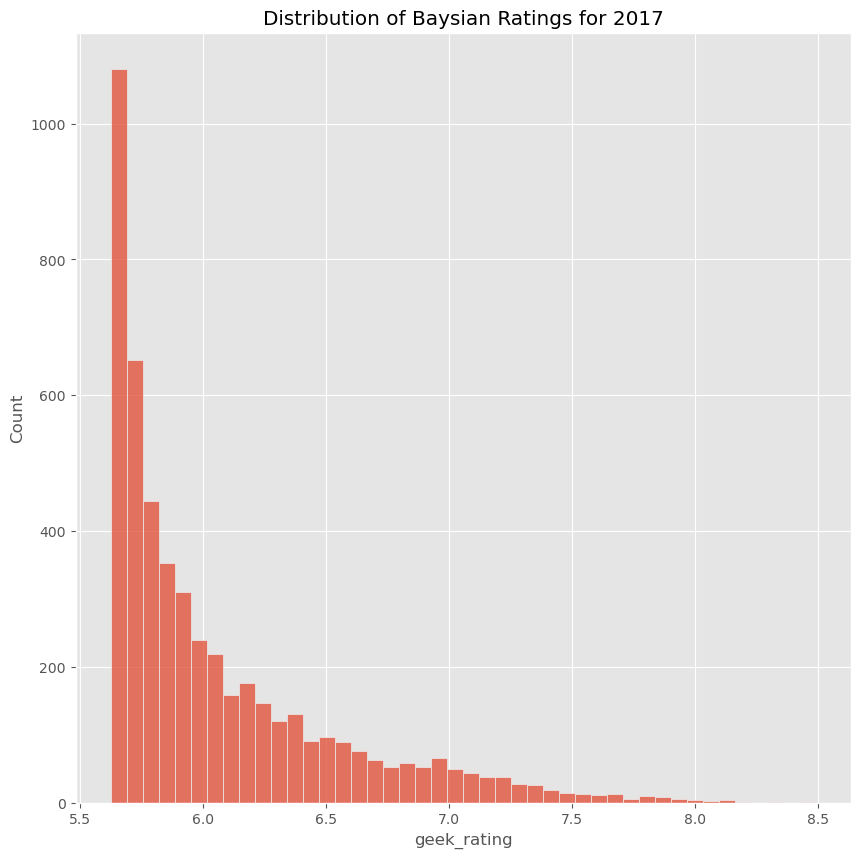

In [104]:
plt.title('Distribution of Baysian Ratings for 2017')
sns.histplot(data=df_17, x='geek_rating')
plt.savefig('figures/Distribution of Baysian Ratings for 2017.pdf')

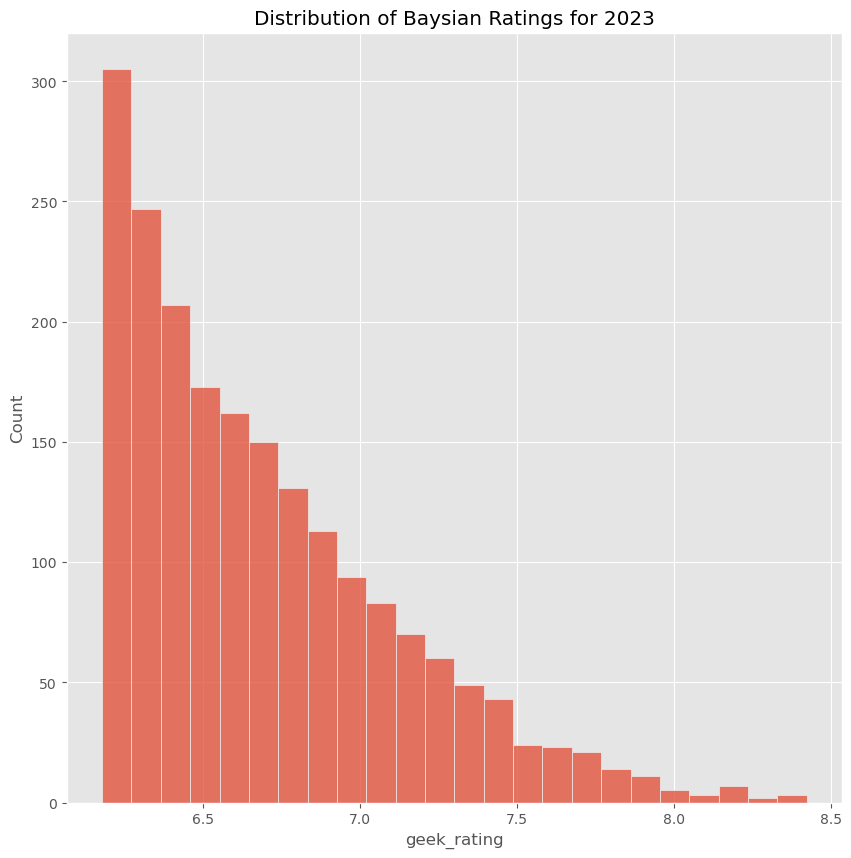

In [105]:
plt.title('Distribution of Baysian Ratings for 2023')
sns.histplot(data=df_23, x='geek_rating')
plt.savefig('figures/Distribution of Baysian Ratings for 2023.pdf')

In [24]:
# spearman correlations
mask_17 = df_17[['geek_rating',
                 'min_players',
                 'max_players',
                 'avg_time',
                 'min_time',
                 'max_time',
                 'num_votes',
                 'weight']]
mask_17.corr(method='spearman').round(3)

,rank,geek_rating,min_players,max_players,avg_time,min_time,max_time,num_votes,weight
rank,1.000,-1.000,0.009,-0.041,-0.134,-0.096,-0.138,-0.850,-0.156
geek_rating,-1.000,1.000,-0.009,0.041,0.134,0.096,0.138,0.850,0.156
min_players,0.009,-0.009,1.000,0.315,-0.086,-0.028,-0.083,0.094,-0.180
max_players,-0.041,0.041,0.315,1.000,-0.088,-0.094,-0.085,0.174,-0.264
avg_time,-0.134,0.134,-0.086,-0.088,1.000,0.926,0.992,-0.039,0.744
min_time,-0.096,0.096,-0.028,-0.094,0.926,1.000,0.916,-0.045,0.701
max_time,-0.138,0.138,-0.083,-0.085,0.992,0.916,1.000,-0.031,0.739
num_votes,-0.850,0.850,0.094,0.174,-0.039,-0.045,-0.031,1.000,-0.096
weight,-0.156,0.156,-0.180,-0.264,0.744,0.701,0.739,-0.096,1.000


In [25]:
for col in mask_17:
    rho, p = spearmanr(mask_17['rank'], mask_17[col])
    print(f'{col} correlation with geek_rating:', 'rho=%.3f, p=%.3f' % (rho,p))

rank correlation with geek_rating: rho=1.000, p=0.000
geek_rating correlation with geek_rating: rho=-1.000, p=0.000
min_players correlation with geek_rating: rho=0.009, p=0.544
max_players correlation with geek_rating: rho=-0.041, p=0.004
avg_time correlation with geek_rating: rho=-0.134, p=0.000
min_time correlation with geek_rating: rho=-0.096, p=0.000
max_time correlation with geek_rating: rho=-0.138, p=0.000
num_votes correlation with geek_rating: rho=-0.850, p=0.000
weight correlation with geek_rating: rho=-0.156, p=0.000


## Constructing model:

In [33]:
for df in df_list:
    features = df[['avg_time',
                  'min_time',
                  'max_time',
                  'num_votes',
                  'weight']]
    target = df.geek_rating
    
    X = features
    y = target
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)
    
    model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
    y_pred = model.predict(sm.add_constant(X_test))
    print(model.summary())
    
    #Check for Variance Inflation Factor (VIF) for Multicoolinearity Issues

    x_temp = sm.add_constant(X_train)

    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(x_temp.values, i) for i in range(x_temp.values.shape[1])]
    vif["features"] = x_temp.columns
    print(vif.round(1))
    

                            OLS Regression Results                            
Dep. Variable:            geek_rating   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     576.7
Date:                Wed, 26 Jul 2023   Prob (F-statistic):               0.00
Time:                        14:15:38   Log-Likelihood:                -1453.0
No. Observations:                3749   AIC:                             2918.
Df Residuals:                    3743   BIC:                             2955.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6658      0.018    309.012      0.0

C:\Users\mhous\.conda\envs\IS_407\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [93]:
for df in df_list:
#     df['easy'] = (df['weight'] < 3.0).astype(int)
#     df['medium'] = ((df['weight'] >= 3.0) & (df['weight'] < 4.0)).astype(int)
#     df['hard'] = (df['weight'] >= 4.0).astype(int)
    df['avg_players'] = (df['max_players'] + df['min_players'])/2
    df['avg_time'] = (df['max_time'] + df['min_time'])/2
    
    conditions = [
    (df['weight'] < 3.0),
    (df['weight'] >= 3.0) & (df['weight'] < 4.0),
    (df['weight'] >= 4.0)
]
    values = [0,1,2]
    df['difficulty'] = np.select(conditions, values)
df_17.head()

,rank,bgg_url,game_id,name,min_players,max_players,avg_time,min_time,max_time,year,...,image_url,age,owned,designer,weight,easy,medium,hard,avg_players,difficulty
0,1,https://boardgamegeek.com/boardgame/161936/pan...,161936,Pandemic Legacy: Season 1,2,4,60.0,60,60,2015,...,https://cf.geekdo-images.com/images/pic2452831...,13,29472,"Rob Daviau, Matt Leacock",2.8076,1,0,0,3.0,0
1,2,https://boardgamegeek.com/boardgame/182028/thr...,182028,Through the Ages: A New Story of Civilization,2,4,210.0,180,240,2015,...,https://cf.geekdo-images.com/images/pic2663291...,14,10007,Vlaada Chvátil,4.3093,0,0,1,3.0,2
2,3,https://boardgamegeek.com/boardgame/12333/twil...,12333,Twilight Struggle,2,2,180.0,180,180,2005,...,https://cf.geekdo-images.com/images/pic361592.jpg,13,37382,"Ananda Gupta, Jason Matthews",3.5317,0,1,0,2.0,1
3,4,https://boardgamegeek.com/boardgame/120677/ter...,120677,Terra Mystica,2,5,105.0,60,150,2012,...,https://cf.geekdo-images.com/images/pic1356616...,12,27948,"Jens Drögemüller, Helge Ostertag",3.9387,0,1,0,3.5,1
4,5,https://boardgamegeek.com/boardgame/174430/glo...,174430,Gloomhaven,1,4,120.0,90,150,2017,...,https://cf.geekdo-images.com/images/pic2437871...,12,6057,Isaac Childres,3.7028,0,1,0,2.5,1


In [98]:
features = df_23[['avg_time',
               'avg_players',
               'num_votes',
               'difficulty']]

target = np.log1p(df_23['rank'])

X = features
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
y_pred = model.predict(sm.add_constant(X_test))
print(model.summary())

#Check for Variance Inflation Factor (VIF) for Multicoolinearity Issues

x_temp = sm.add_constant(X_train)

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x_temp.values, i) for i in range(x_temp.values.shape[1])]
vif["features"] = x_temp.columns
print(vif.round(1))

percent_effect = (np.exp(model.params) - 1) * 100
print(percent_effect)

                            OLS Regression Results                            
Dep. Variable:                   rank   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     308.2
Date:                Thu, 27 Jul 2023   Prob (F-statistic):          2.11e-193
Time:                        12:17:45   Log-Likelihood:                -1681.4
No. Observations:                1500   AIC:                             3373.
Df Residuals:                    1495   BIC:                             3399.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.1352      0.034    209.423      

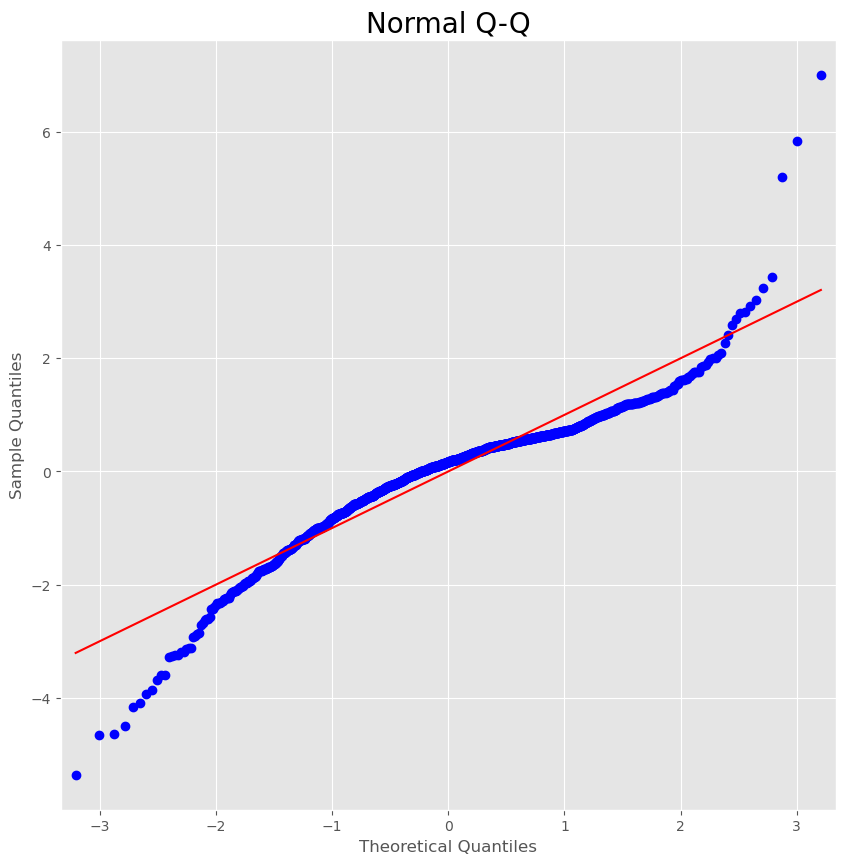

In [90]:
#Normal Q-Q Plot

plt.rc('figure', figsize=(10,10))
plt.style.use('ggplot')

sm.qqplot(model.resid, line='s', fit=True, markerfacecolor='blue',
                                      markeredgecolor='blue',);
plt.title('Normal Q-Q', fontsize=20)
plt.show()

In [96]:
df_23['time_difficulty_interaction'] = df_23['avg_time'] * df_23['difficulty']

features = df_23[['avg_time', 'avg_players', 'num_votes', 'difficulty', 'time_difficulty_interaction']]

target = np.log1p(df_23['rank'])

X = features
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
y_pred = model.predict(sm.add_constant(X_test))
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   rank   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     247.2
Date:                Wed, 26 Jul 2023   Prob (F-statistic):          1.28e-192
Time:                        17:15:23   Log-Likelihood:                -1680.2
No. Observations:                1500   AIC:                             3372.
Df Residuals:                    1494   BIC:                             3404.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             